In [236]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models, transforms, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Hyper-parameters
* Hyper-parameters suggested by the original paper

In [238]:
bs=1 # suggested by the paper
lr=0.0002 
beta1=0.5
beta2=0.999
NUM_EPOCHS = 200
ngpu = 1
L1_lambda = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Import  Dataset and load them into batches

In [239]:
data_dir = "maps"

data_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.CenterCrop((256, 512)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset_train = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=data_transform)
# dataset_val = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=data_transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=0)
# dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=24, shuffle=True, num_workers=0)./

In [240]:
images,_ = next(iter(dataloader_train))

sample_sat = images[0][:,:,:256]
sample_map = images[0][:,:,256:]

In [241]:
for images, labels in dataloader_train:
    print(f"First image tensor: {images[0]}")  # print pixel values of the first image
    break
print(data_dir)
print(len(dataset_train))
print(len(dataloader_train))

First image tensor: tensor([[[-0.6941, -0.6392, -0.3098,  ...,  0.5922,  0.5922,  0.5922],
         [-0.7412, -0.7333, -0.5137,  ...,  0.5922,  0.5922,  0.5922],
         [-0.7333, -0.7490, -0.6784,  ...,  0.5922,  0.5922,  0.5922],
         ...,
         [-0.6078, -0.5373, -0.8196,  ...,  0.8353,  0.8353,  0.8510],
         [-0.6392, -0.6784, -0.7961,  ...,  0.8196,  0.8275,  0.8745],
         [-0.5922, -0.6471, -0.4902,  ...,  0.8118,  0.8275,  0.8902]],

        [[-0.6471, -0.5922, -0.2784,  ...,  0.7490,  0.7490,  0.7490],
         [-0.6941, -0.6863, -0.4745,  ...,  0.7490,  0.7490,  0.7490],
         [-0.6784, -0.6941, -0.6392,  ...,  0.7490,  0.7490,  0.7490],
         ...,
         [-0.6000, -0.5294, -0.8118,  ...,  0.7804,  0.7647,  0.7804],
         [-0.6314, -0.6706, -0.7882,  ...,  0.7647,  0.7569,  0.7961],
         [-0.5843, -0.6392, -0.4824,  ...,  0.7569,  0.7490,  0.8118]],

        [[-0.6784, -0.6235, -0.2863,  ...,  0.3490,  0.3490,  0.3490],
         [-0.7255, -0.717

# Define function to show image

In [242]:
def show_image(img, title="No title", figsize=(5,5)):
    img = img.numpy().transpose(1,2,0)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    img = img * std + mean
    np.clip(img, 0, 1)
    
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.title(title)

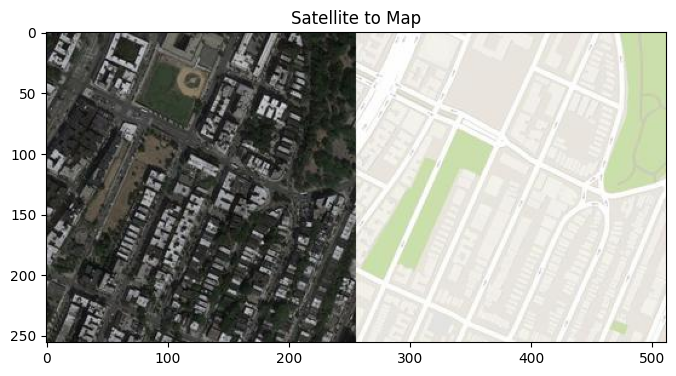

In [243]:
show_image(images[0], title="Satellite to Map", figsize=(8,8))

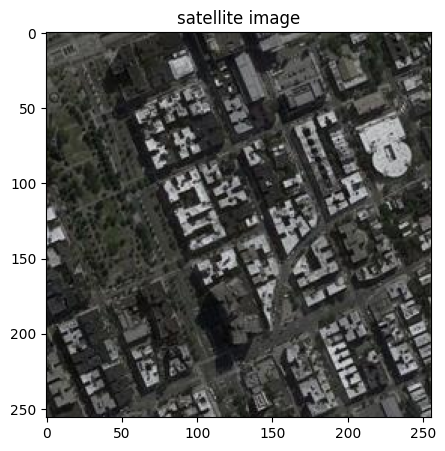

In [244]:
show_image(img = sample_sat, title = "satellite image", figsize=(5,5))

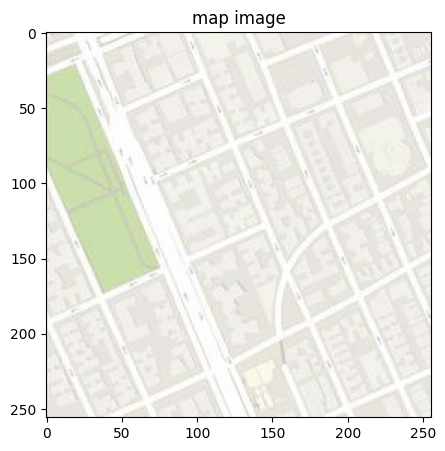

In [245]:
show_image(img = sample_map, title = "map image", figsize=(5, 5))

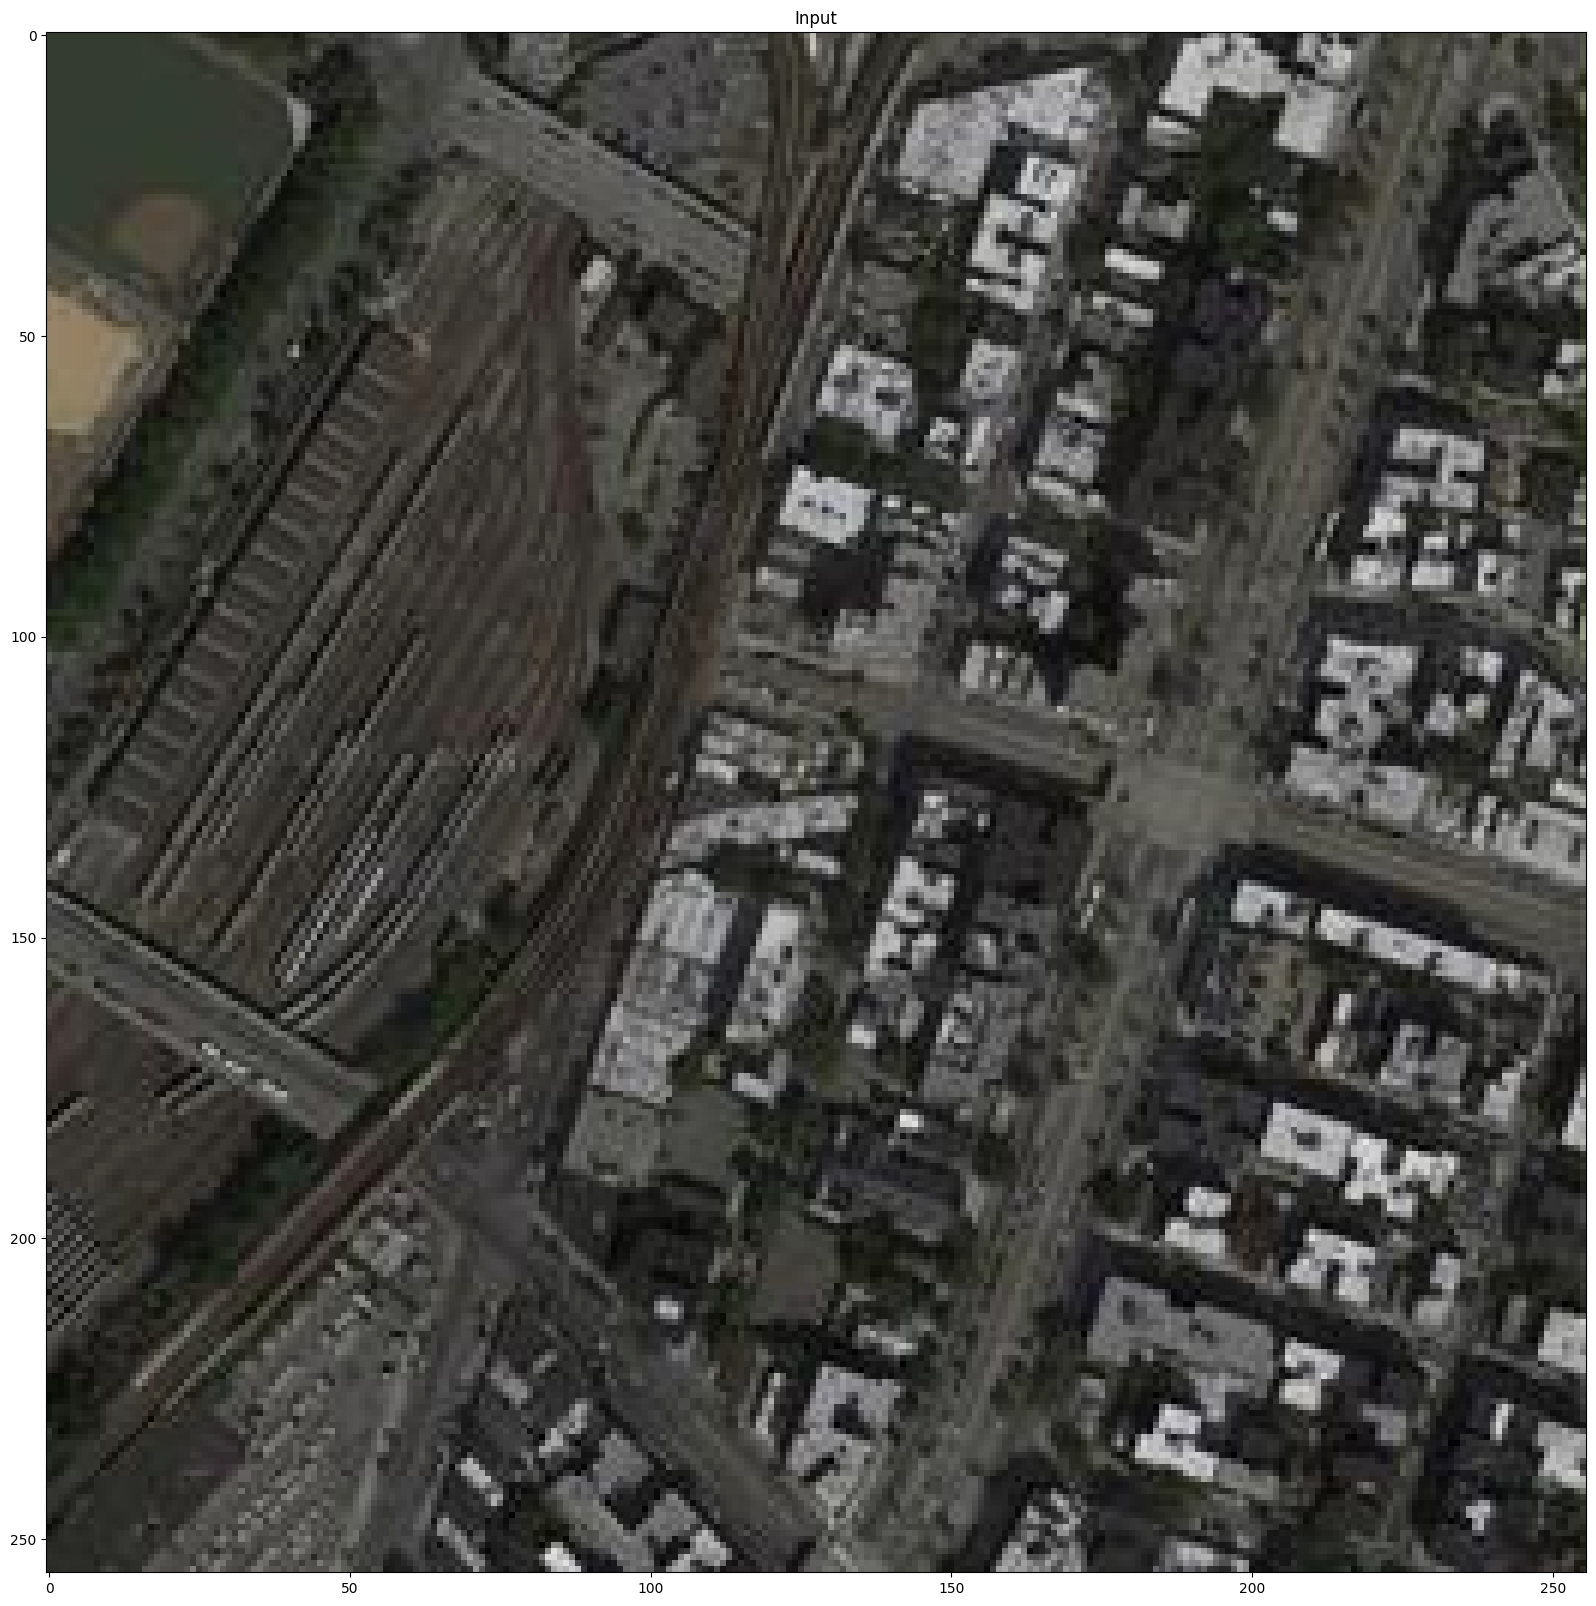

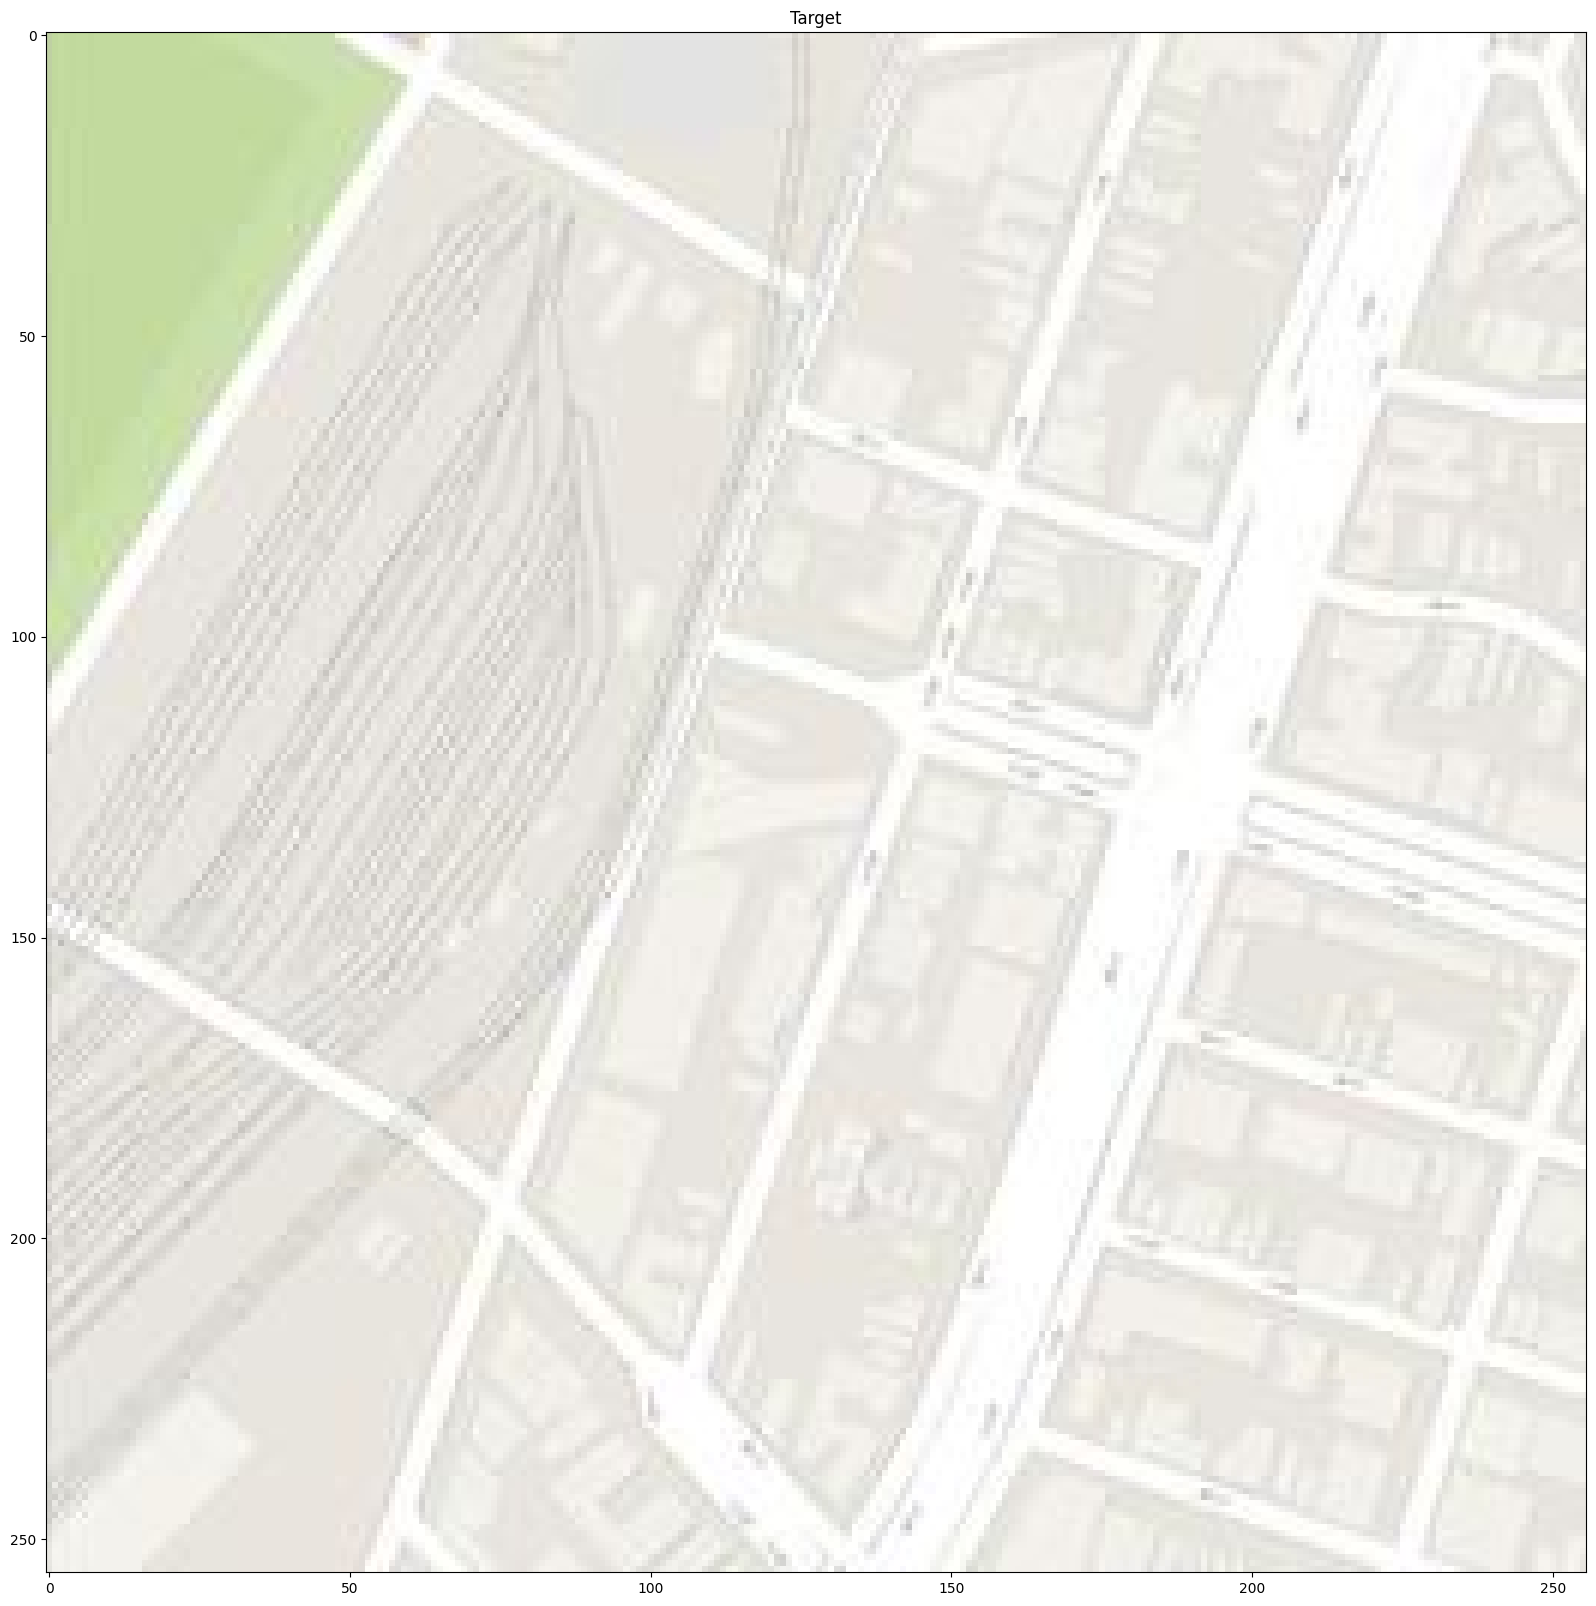

In [246]:
images,_ = next(iter(dataloader_train))
x = torchvision.utils.make_grid(images[:,:,:,:256], padding=10)
y = torchvision.utils.make_grid(images[:,:,:,256:], padding=10)

show_image(x, title="Input", figsize=(20,20))
show_image(y, title="Target", figsize=(20,20))

# Function to initialize model's weights

In [247]:
def weights_init(m):
    name = m.__class__.__name__
    
    if(name.find("Conv") > -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02) # ~N(mean=0.0, std=0.02)
    elif(name.find("BatchNorm") > -1):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

# 1.1 Generator - Architecture
* The architecture is U-Net 256

* In 3 x 256 x 256 - Encoder C64 - C128 - C256 - C512 - C512 - C512
- C512 (Latent space)
* Decoder DC1024 - DC1024 - DC1024 - DC512 - DC256 - DC128 - Out 3 x 256 x 256
* Reference: https://arxiv.org/pdf/1505.04597.pdf

In [248]:
"""
    The Generator is a U-Net 256 with skip connections between Encoder and Decoder
"""

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        """
        ===== Encoder ======
        
        * Encoder has the following architecture:
        0) Inp3 
        1) C64 
        2) Leaky, C128, Norm 
        3) Leaky, C256, Norm 
        4) Leaky, C512, Norm 
        5) Leaky, C512, Norm 
        6) Leaky, C512, Norm 
        7) Leaky, C512
        
        * The structure of 1 encoder block is:
        1) LeakyReLU(prev layer)
        2) Conv2D
        3) BatchNorm
        
        Where Conv2D has kernel_size-4, stride=2, padding=1 for all layers
        """
        self.encoder1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
        
        self.encoder2 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128)
        )
        
        self.encoder3 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
        )
        
        self.encoder4 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )
        
        self.encoder5 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )
        
        self.encoder6 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )
        
        self.encoder7 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False)
        )
        
        """
        ===== Decoder =====
        * Decoder has the following architecture:
        1) ReLU(from latent space), DC512, Norm, Drop 0.5 - Residual
        2) ReLU, DC512, Norm, Drop 0.5, Residual
        3) ReLU, DC512, Norm, Drop 0.5, Residual
        4) ReLU, DC256, Norm, Residual
        5) ReLU, DC128, Norm, Residual
        6) ReLU, DC64, Norm, Residual
        7) ReLU, DC3, Tanh()
        
        * Note: only apply Dropout in the first 3 Decoder layers
        
        * The structure of each Decoder block is:
        1) ReLU(from prev layer)
        2) ConvTranspose2D
        3) BatchNorm
        4) Dropout
        5) Skip connection
        
        Where ConvTranpose2D has kernel_size=4, stride=2, padding=1
        """
        self.decoder1 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)
        )
        # skip connection in forward()
        
        self.decoder2 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)
        )
        # skip connection in forward()
        
        self.decoder3 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)
        )
        # skip connection in forward()
        
        self.decoder4 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512*2, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            #nn.Dropout(0.5)
        )
        
        self.decoder5 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=256*2, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            #nn.Dropout(0.5)
        )
        
        self.decoder6 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128*2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            #nn.Dropout(0.5)
        )
        
        self.decoder7 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64*2, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        
        latent_space = self.encoder7(e6)
        
        d1 = torch.cat([self.decoder1(latent_space), e6], dim=1)
        d2 = torch.cat([self.decoder2(d1), e5], dim=1)
        d3 = torch.cat([self.decoder3(d2), e4], dim=1)
        d4 = torch.cat([self.decoder4(d3), e3], dim=1)
        d5 = torch.cat([self.decoder5(d4), e2], dim=1)
        d6 = torch.cat([self.decoder6(d5), e1], dim=1)
        
        out = self.decoder7(d6)
        
        return out

# 1.2 Generator - Initialization

In [287]:
pip install torchsummary


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [256]:
import torch
import torch.nn as nn
from torchsummary import summary

In [258]:


# Assuming the Generator class and weights_init function are defined elsewhere
# Define or import your Generator model and weights initialization function

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Add the layers of your generator model here
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Set device (CUDA or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ngpu = 1  # Adjust according to the number of GPUs

# Initialize the generator model
model_G = Generator(ngpu=ngpu)

# If using multiple GPUs, wrap the model with DataParallel
if device.type == 'cuda' and ngpu > 1:
    model_G = nn.DataParallel(model_G, list(range(ngpu)))

# Apply the weights_init function to initialize the model's weights
model_G.apply(weights_init)

# Move the model to the device (GPU/CPU)
model_G.to(device)

# Print model summary (for input size of 100x1x1 for example)
# Adjust the input size as per the Generator's expected input
summary(model_G, input_size=(100, 1, 1))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [249]:
# model_G = Generator(ngpu=1)

# if(device == "cuda" and ngpu > 1):
#     model_G = nn.DataParallel(model_G, list(range(ngpu)))
    
# model_G.apply(weights_init)
# model_G.to(device)

Generator(
  (encoder1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (encoder2): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder3): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder4): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder5): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(512, 512, kernel_s

In [259]:
model_G.to(device)
#model_G(images[:,:,:,:256]).shape

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# 2.1 Discriminator - Architecture
* PatchGan Discriminator with receptive field of each patch is **rf = 70x70**
* Structure is **C64 (no norm, 4,2,1)-C128 (4,2,1)-C256 (4,2,1)-C512 (4,1,1) - Channel 1 (4,1,1)**, where C is Convolution - BatchNorm - LeakyReLU
* Activations are **LeakyReLU(0.2)**
* BatchNorm is applied to all layers but C64
* Last 2 layers has **kernel_size=4, stride=1, padding=1**

In [260]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        self.structure = nn.Sequential(
            nn.Conv2d(in_channels=3*2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.structure(x)

# 2.2 Discriminator Initialization

In [261]:
model_D = Discriminator(ngpu=1)

if(device == "cuda" and ngpu>1):
    model_D = torch.DataParallel(model_D, list(rang(ngpu)))
    
model_D.apply(weights_init)
model_D.to(device)

Discriminator(
  (structure): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [262]:
out1 = model_D(torch.cat([images[:,:,:,:256].to(device), images[:,:,:,256:].to(device)], dim=1)).to(device)
out2 = torch.ones(size=out1.shape, dtype=torch.float, device=device)

print(out1.shape)
print(criterion(out1, out2))

torch.Size([1, 1, 30, 30])
tensor(1.2384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


# 3. Training process
* We train Generator 2 times for each time we train Discriminator

* Let $x$ be the input satellite image and $y$ be the ground-truth map image. The objective is to train the U-Net Generator $G$ so that it can translate satellite image to a map image as realistic as possible.

In [286]:
# criterion = nn.BCELoss()

# optimizerD = optim.Adam(model_D.parameters(), lr=lr, betas=(beta1, beta2))
# optimizerG = optim.Adam(model_G.parameters(), lr=lr, betas=(beta1, beta2))

# NUM_EPOCHS=171
# model_D.to(device)/
# model_G.to(device)
# print()

In [60]:
# L1_lambda = 100
# NUM_EPOCHS= 50

In [285]:
# for epoch in range(NUM_EPOCHS+1):
#     print(f"Training epoch {epoch+1}")
#     for images,_ in iter(dataloader_train):
#         # ========= Train Discriminator ===========
#         # Train on real data
#         # Maximize log(D(x,y)) <- maximize D(x,y)
#         model_D.zero_grad()
        
#         inputs = images[:,:,:,:256].to(device) # input image data
#         targets = images[:,:,:,256:].to(device) # real targets data
        
#         real_data = torch.cat([inputs, targets], dim=1).to(device)
#         outputs = model_D(real_data) # label "real" data
#         labels = torch.ones(size = outputs.shape, dtype=torch.float, device=device)
        
#         lossD_real = 0.5 * criterion(outputs, labels) # divide the objective by 2 -> slow down D
#         lossD_real.backward()
        
#         # Train on fake data
#         # Maximize log(1-D(x,G(x))) <- minimize D(x,G(x))
#         gens = model_G(inputs).detach()
         
#         fake_data = torch.cat([inputs, gens], dim=1) # generated image data
#         outputs = model_D(fake_data)
#         labels = torch.zeros(size = outputs.shape, dtype=torch.float, device=device) # label "fake" data
        
#         lossD_fake = 0.5 * criterion(outputs, labels) # divide the objective by 2 -> slow down D
#         lossD_fake.backward()
        
#         optimizerD.step()
        
#         # ========= Train Generator x2 times ============
#         # maximize log(D(x, G(x)))
#         for i in range(2):
#             model_G.zero_grad()
            
#             gens = model_G(inputs)
            
#             gen_data = torch.cat([inputs, gens], dim=1) # concatenated generated data
#             outputs = model_D(gen_data)
#             labels = torch.ones(size = outputs.shape, dtype=torch.float, device=device)
            
#             lossG = criterion(outputs, labels) + L1_lambda * torch.abs(gens-targets).sum()
#             lossG.backward()
#             optimizerG.step()
            
#     if(epoch%5==0):
#         torch.save(model_G, "./sat2mapGen_v1.3.pth")
#         torch.save(model_D, "./sat2mapDisc_v1.3.pth")
    
# print("Done!")

# 4. Results

In [263]:
model_G = Generator(ngpu=1)
model_G.apply(weights_init)  # You can remove this line if the model is pre-trained.


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [292]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

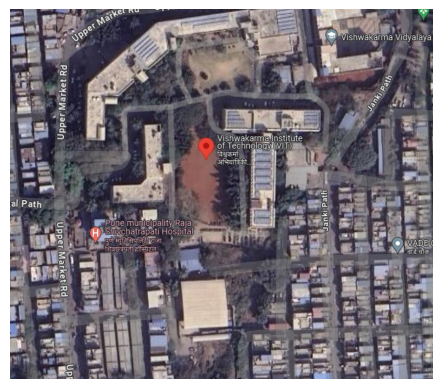

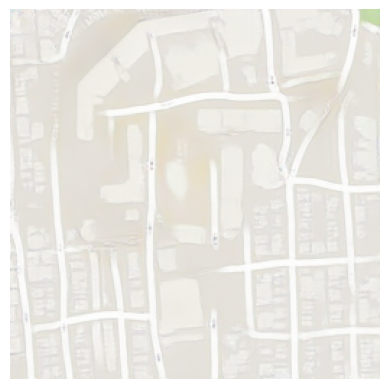

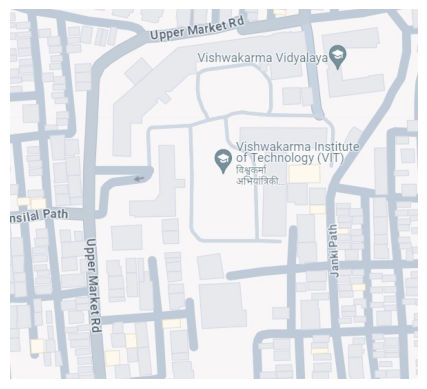

In [295]:


# Load and display the image
img = mpimg.imread('1_A.jpeg')
imgplot = plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

img = mpimg.imread('vit_map_gen.png')
imgplot = plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

img = mpimg.imread('vit_google.jpeg')
imgplot = plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()




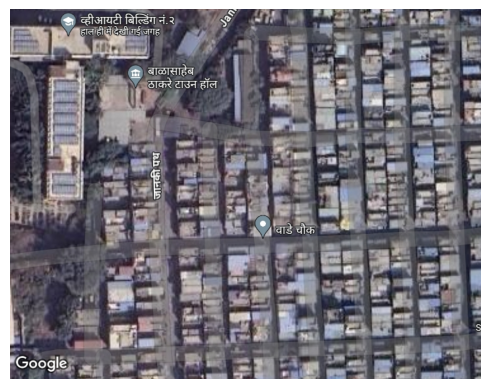

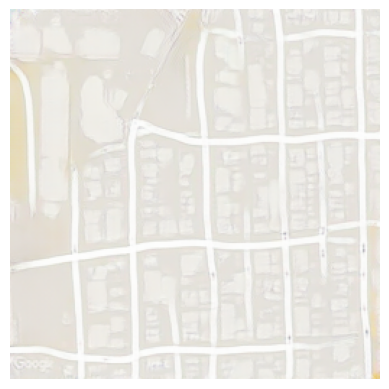

In [297]:
img = mpimg.imread('vit2_A.jpeg')
imgplot = plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

img = mpimg.imread('vit2_sat_gen.png')
imgplot = plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

# img = mpimg.imread('vit_google.jpeg')
# imgplot = plt.imshow(img)
# plt.axis('off')  # Hide the axis
# plt.show()

In [265]:
# # 1. Instantiate the Generator model

# # 2. Load the saved state dictionary (pre-trained weights)
# state_dict = torch.load("50_net_G_A.pth")

# # 3. Load the state dict into the model
# # model_G.load_state_dict(state_dict)

# # 4. Apply weight initialization if needed (before loading the state_dict)

# # 5. Move the model to the appropriate device (GPU or CPU)
# model_G = model_G.to(device)

# # Now, proceed with your testing code
# test_imgs, _ = next(iter(dataloader_train))

# satellite = test_imgs[:, :, :, :256].to(device)
# maps = test_imgs[:, :, :, 256:].to(device)

# # Generate the map from the satellite image
# gen = model_G(satellite)

# # Detach tensors from GPU for displaying them
# satellite = satellite.detach().cpu()
# gen = gen.detach().cpu()
# maps = maps.detach().cpu()

# # Show images using matplotlib
# import torchvision
# import matplotlib.pyplot as plt

# def show_image(img, title=None, figsize=(10, 10)):
#     npimg = img.numpy()
#     plt.figure(figsize=figsize)
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     if title:
#         plt.title(title)
#     plt.axis('off')
#     plt.show()

# # Show satellite image, generated map, and expected map
# show_image(torchvision.utils.make_grid(satellite, padding=10), title="Satellite", figsize=(10,10))
# show_image(torchvision.utils.make_grid(gen, padding=10), title="Generated", figsize=(10,10))
# show_image(torchvision.utils.make_grid(maps, padding=10), title="Expected Output", figsize=(10,10))


In [277]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define the preprocessing and postprocessing functions
# def preprocess_image(image_path):
#     data_transform = transforms.Compose([
#         transforms.Resize((256, 256)),  # Resize the image to match the model's input size
#         transforms.ToTensor(),  # Convert the image to a tensor
#         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
#     ])
    
#     image = Image.open(image_path).convert("RGB")  # Open and convert the image to RGB
#     image = data_transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
#     return image.to(device)

# def postprocess_and_show(tensor):
#     # Undo normalization
#     image = tensor.squeeze(0).detach().cpu()  # Remove batch dimension and move to CPU
#     image = (image * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
#     image = image.permute(1, 2, 0).numpy()  # Reorder dimensions for matplotlib (H, W, C)
    
#     # Show the image
#     plt.imshow(image)
#     plt.axis('off')  # Turn off axis labels
#     plt.show()

# # Load the pretrained Generator model
# def load_model(model_path):
#     model = Generator(ngpu=1)  # Initialize the model
#     state_dict = torch.load(model_path, map_location=device)  # Load the state dict
#     model.load_state_dict(state_dict)  # Load the model weights
#     model.to(device)  # Move the model to the device (GPU/CPU)
#     model.eval()  # Set model to evaluation mode
#     return model

# # Main function
# def main():
#     model_path = "50_net_G_A.pth"  # Path to your pretrained model
#     satellite_image_path = input("1.jpeg")  # Get image path from the user
    
#     # Load the model
#     model_G = load_model(model_path)
    
#     # Preprocess the satellite image
#     satellite_image = preprocess_image(satellite_image_path)
    
#     # Generate the map from the satellite image
#     with torch.no_grad():
#         generated_map = model_G(satellite_image)
    
#     # Postprocess and show the generated map
#     postprocess_and_show(generated_map)


In [278]:
# import torch
# import torch.nn as nn
# from PIL import Image
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt

# # Check if CUDA is available and set the device accordingly
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Preprocessing function for the input satellite image
# def preprocess_image(image_path):
#     data_transform = transforms.Compose([
#         transforms.Resize((256, 256)),  # Resize the image to match the model's input size
#         transforms.ToTensor(),  # Convert the image to a tensor
#         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1] as required by GANs
#     ])
    
#     image = Image.open(image_path).convert("RGB")  # Open the image and convert to RGB
#     image = data_transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
#     return image.to(device)  # Move the image to the same device as the model

# # Postprocessing function to display the generated map
# def postprocess_and_show(tensor):
#     # Undo normalization
#     image = tensor.squeeze(0).detach().cpu()  # Remove batch dimension and move to CPU
#     image = (image * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
#     image = image.permute(1, 2, 0).numpy()  # Reorder dimensions for matplotlib (H, W, C)
    
#     # Show the image
#     plt.imshow(image)
#     plt.axis('off')  # Turn off axis labels
#     plt.show()

# # Load the pretrained Generator model
# state_dict = torch.load("50_net_G_A.pth", map_location=device)

# # Assuming the Generator class is already defined (from your earlier code)
# model_G = Generator(ngpu=1)
# model_G.load_state_dict(state_dict)  # Load the model state dictionary
# model_G.to(device)  # Move the model to the device (GPU/CPU)
# model_G.eval()  # Set model to evaluation mode

# # Load satellite input from the user
# satellite_image_path = "1.jpeg"  # Path to satellite image
# satellite_image = preprocess_image(satellite_image_path)  # Preprocess the image

# # Generate the map from the satellite image
# with torch.no_grad():
#     generated_map = model_G(satellite_image)  # Generate the map

# # Postprocess and show the generated map
# postprocess_and_show(generated_map)


In [272]:
# model_G = Generator(ngpu=1)
# model_G.apply(weights_init)

In [271]:
# import torch
# import torch.nn as nn
# from PIL import Image
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt

# # Assuming the Generator model is already defined and initialized (from your provided code)
# # Assuming the model_G and model_D are initialized and ready for inference

# # Preprocessing function for the input satellite image
# def preprocess_image(image_path):
#     data_transform = transforms.Compose([
#         transforms.Resize((256, 256)),  # Resize the image to match the model's input size
#         transforms.ToTensor(),  # Convert the image to a tensor
#         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1] as required by GANs
#     ])
    
#     image = Image.open(image_path).convert("RGB")  # Open the image and convert to RGB
#     image = data_transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
#     return image.to(device)

# # Postprocessing function to display the generated map
# def postprocess_and_show(tensor):
#     # Undo normalization
#     image = tensor.squeeze(0).detach().cpu()  # Remove batch dimension and move to CPU
#     image = (image * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
#     image = image.permute(1, 2, 0).numpy()  # Reorder dimensions for matplotlib (H, W, C)
    
#     # Show the image
#     plt.imshow(image)
#     plt.axis('off')  # Turn off axis labels
#     plt.show()

# # Load the pretrained Generator model

# state_dict = torch.load("50_net_G_A.pth", map_location=device)
# # model_G.load_state_dict(state_dict)
# model_G.eval()  # Set model to evaluation mode

# # Load satellite input from the user
# satellite_image_path = "1.jpeg"  # Get image path from the user
# satellite_image = preprocess_image(satellite_image_path)

# # Generate the map from the satellite image
# with torch.no_grad():
#     generated_map = model_G(satellite_image)

# # Postprocess and show the generated map
# postprocess_and_show(generated_map)


In [234]:
# model_G = torch.load("20_net_G_A.pth")
# model_G.apply(weights_init)
# test_imgs,_ = next(iter(dataloader_train))

# satellite = test_imgs[:,:,:,:256].to(device)
# maps = test_imgs[:,:,:,256:].to(device)

# gen = model_G(satellite)
# #gen = gen[0]

# satellite = satellite.detach().cpu()
# gen = gen.detach().cpu()
# maps = maps.detach().cpu()

# show_image(torchvision.utils.make_grid(satellite, padding=10), title="Satellite", figsize=(50,50))
# show_image(torchvision.utils.make_grid(gen, padding=10), title="Generated", figsize=(50,50))
# show_image(torchvision.utils.make_grid(maps, padding=10), title="Expected Output", figsize=(50,50))

In [280]:
# show_image(maps, title="Expected Output", figsize=(5,5))

In [178]:
#print(model_D(torch.cat([satellite[6,:,:,:].reshape(1,3,256,256).to(device), gen[6,:,:,:].reshape(1,3,256,256).to(device)], dim=1)))

In [179]:
#torch.save(model_G, "./sat2mapGen_v1.1.pth")
#torch.save(model_D, "./sat2mapDisc_v1.1.pth")

In [138]:
# model_G = torch.load("20_net_G_A.pth")
# model_G.apply(weights_init)


In [282]:

# # Define your Generator model class as before
# """
#     The Generator is a U-Net 256 with skip connections between Encoder and Decoder"
#         # Define model architecture here (copy your Generator class definition)

#     # def forward(self, x):
#     #     # Define forward pass here (copy your forward method)
#     #     return out

# # Define the same transformations used during training
# data_transform = transforms.Compose([
#     transforms.Resize((256, 512)),
#     transforms.CenterCrop((256, 512)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
# ])

# # Load the trained generator model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initialize the model and load the state dictionary
# model_G = Generator(ngpu=1)
# model_G.load_state_dict(torch.load("20_net_G_A.pth"))
# model_G.to(device)
# model_G.eval()  # Set model to evaluation mode

# # Function to preprocess the input image
# def preprocess_image(image_path):
#     image = Image.open(image_path).convert("RGB")
#     image = data_transform(image)
#     image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
#     return image

# # Function to postprocess and visualize the output map
# def postprocess_and_show(image_tensor):
#     image_tensor = image_tensor.squeeze(0)  # Remove batch dimension
#     image_tensor = image_tensor * 0.5 + 0.5  # Reverse normalization
#     image = image_tensor.cpu().detach().numpy()
#     image = np.transpose(image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    
#     plt.figure(figsize=(8, 8))
#     plt.imshow(image)
#     plt.axis("off")  # Hide axis
#     plt.title("Generated Map from Satellite Image")
#     plt.show()

# # Load and preprocess the satellite image
# satellite_image_path = "1.jpeg"  # Replace with your satellite image path
# satellite_image = preprocess_image(satellite_image_path)

# # Generate the map from the satellite image
# with torch.no_grad():
#     generated_map = model_G(satellite_image)  # Call the model instance, not the state dict

# # Postprocess and display the generated map
# postprocess_and_show(generated_map)


In [284]:

# # Define the same transformations used during training
# data_transform = transforms.Compose([
#     transforms.Resize((256, 512)),
#     transforms.CenterCrop((256, 512)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
# ])

# # Load the trained generator model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model1_G = torch.load("20_net_G_A.pth")
# # model1_G.to(device)
# # model1_G.eval()  # Set model to evaluation mode

# # Function to preprocess the input image
# def preprocess_image(image_path):
#     image = Image.open(image_path).convert("RGB")
#     image = data_transform(image)
#     image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
#     return image

# # Function to postprocess and visualize the output map
# def postprocess_and_show(image_tensor):
#     image_tensor = image_tensor.squeeze(0)  # Remove batch dimension
#     image_tensor = image_tensor * 0.5 + 0.5  # Reverse normalization
#     image = image_tensor.cpu().detach().numpy()
#     image = np.transpose(image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    
#     plt.figure(figsize=(8, 8))
#     plt.imshow(image)
#     plt.axis("off")  # Hide axis
#     plt.title("Generated Map from Satellite Image")
#     plt.show()

# # Load and preprocess the satellite image
# satellite_image_path = "1.jpeg"  # Replace with your satellite image path
# satellite_image = preprocess_image(satellite_image_path)

# # Generate the map from the satellite image
# with torch.no_grad():
#     generated_map = model1_G(satellite_image)

# # Postprocess and display the generated map
# postprocess_and_show(generated_map)


# Random Experiment zone (trivial stuffs)

In [107]:
inp = images[:,:,:,:256]
target = images[:,:,:,256:]

print(inp.shape)
print(target.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [108]:
data_real = torch.cat([inp, target], dim=1)
print(data_real.shape)

torch.Size([1, 6, 256, 256])


In [109]:
transformmm = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [110]:
datasettt = datasets.ImageFolder(root=os.path.join(data_dir,"train"), transform=transformmm)

In [111]:
dataloaderrrr = torch.utils.data.DataLoader(datasettt, batch_size=1, shuffle=True, num_workers=0)

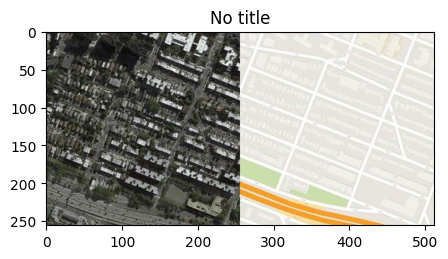

In [112]:
imgsss,_ = next(iter(dataloaderrrr))
show_image(imgsss[0,:,:,:])

In [113]:
name = "TransposeConv2d"
print(name.find("Conv"))

9


In [114]:
a = torch.ones(size=(8,3,5,5))
b = torch.zeros(size=(8,3,5,5))

torch.abs(a-b).sum()

tensor(600.)

Train 200 epochs with $\lambda = 100$ then retrain with $\lambda = 50$